## Notebook 5: Image classifier using VGG16

To address our problem statement of building an image classifier to identify 12 classes of hawker food, we will be building two groups of models as follows: 

- Group 1: Own convolutional neural network (CNN) model with its respective layers (e.g. Conv2D, MaxPool2D, Dropout, Dense layers)
- Group 2: Transfer learning using pre-trained models (i.e. MobileNetV2, VGG16 and ResNet50) for feature extraction and prediction. 

In Notebook 3, we have built our own CNN model by detailing the necessary layers (e.g. Conv2D, MaxPool2D, dropout, Dense layers). For Notebooks 4-6, we will be shifting our focus to look at transfer learning using pre-trained models. Specifically, we will be looking at MobileNet, ResNet50 and VGG16 as pre-trained models to help with feature extraction and classification thereafter. As pre-trained models have been trained on 1000 classes of images from ImageNet, they are good at detecting high-level features like edges, patterns etc. This thus helps in quicker convergence (and often with high accuracy), making it the preferred approach to tasks like object detection.  

### 5.1: Importing libraries and setting parameters

In [1]:
#Importing the necessary libraries
import os
import sys 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=sys.maxsize)


In [2]:
#Instructing Jupyter notebook to use GPU when running VGG16
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')


# As VGG16 requires special pre-processing of images, we will also import the necessary input
from keras.applications.vgg16 import preprocess_input

In [3]:
#Setting out the necessary parameters to train our model
img_width, img_height = 224, 224 
train_data_dir = '../Datasets/Final/Training'
validation_data_dir = '../Datasets/Final/Validation'
test_data_dir= '../Datasets/Final/Test'
batch_size = 32
num_train = 12000
num_validation = 2400

### 5.2: Data augmentation
To prevent any overfitting in our model, we will undertake data augmentation to aritifically created more images out of the exisiting 12,000 training images that we have. Main techniques used include rotation, shifting images upwards/downward or left/right, horizontal flip, zooming in/out at random etc.([*Source: Nanonets*](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)).


In [4]:
# Data augmentation our 12,000 training images
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                 rotation_range=20,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 shear_range=0.1,
                 zoom_range=0.1,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 preprocessing_function=preprocess_input)

# Data augmentation our 2,400 validation images (note: only rescale for these images)
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input)

# Function that reads images from our designated training path and augmenting the images
# within as per our data augementation parameters above 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Function that reads images from our designated validation path and augmenting the images
# within as per our data augementation parameters above 
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Map index to class names
classes = dict((v, k.replace('_', ' ').title()) for k, v in train_generator.class_indices.items())

Found 12000 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

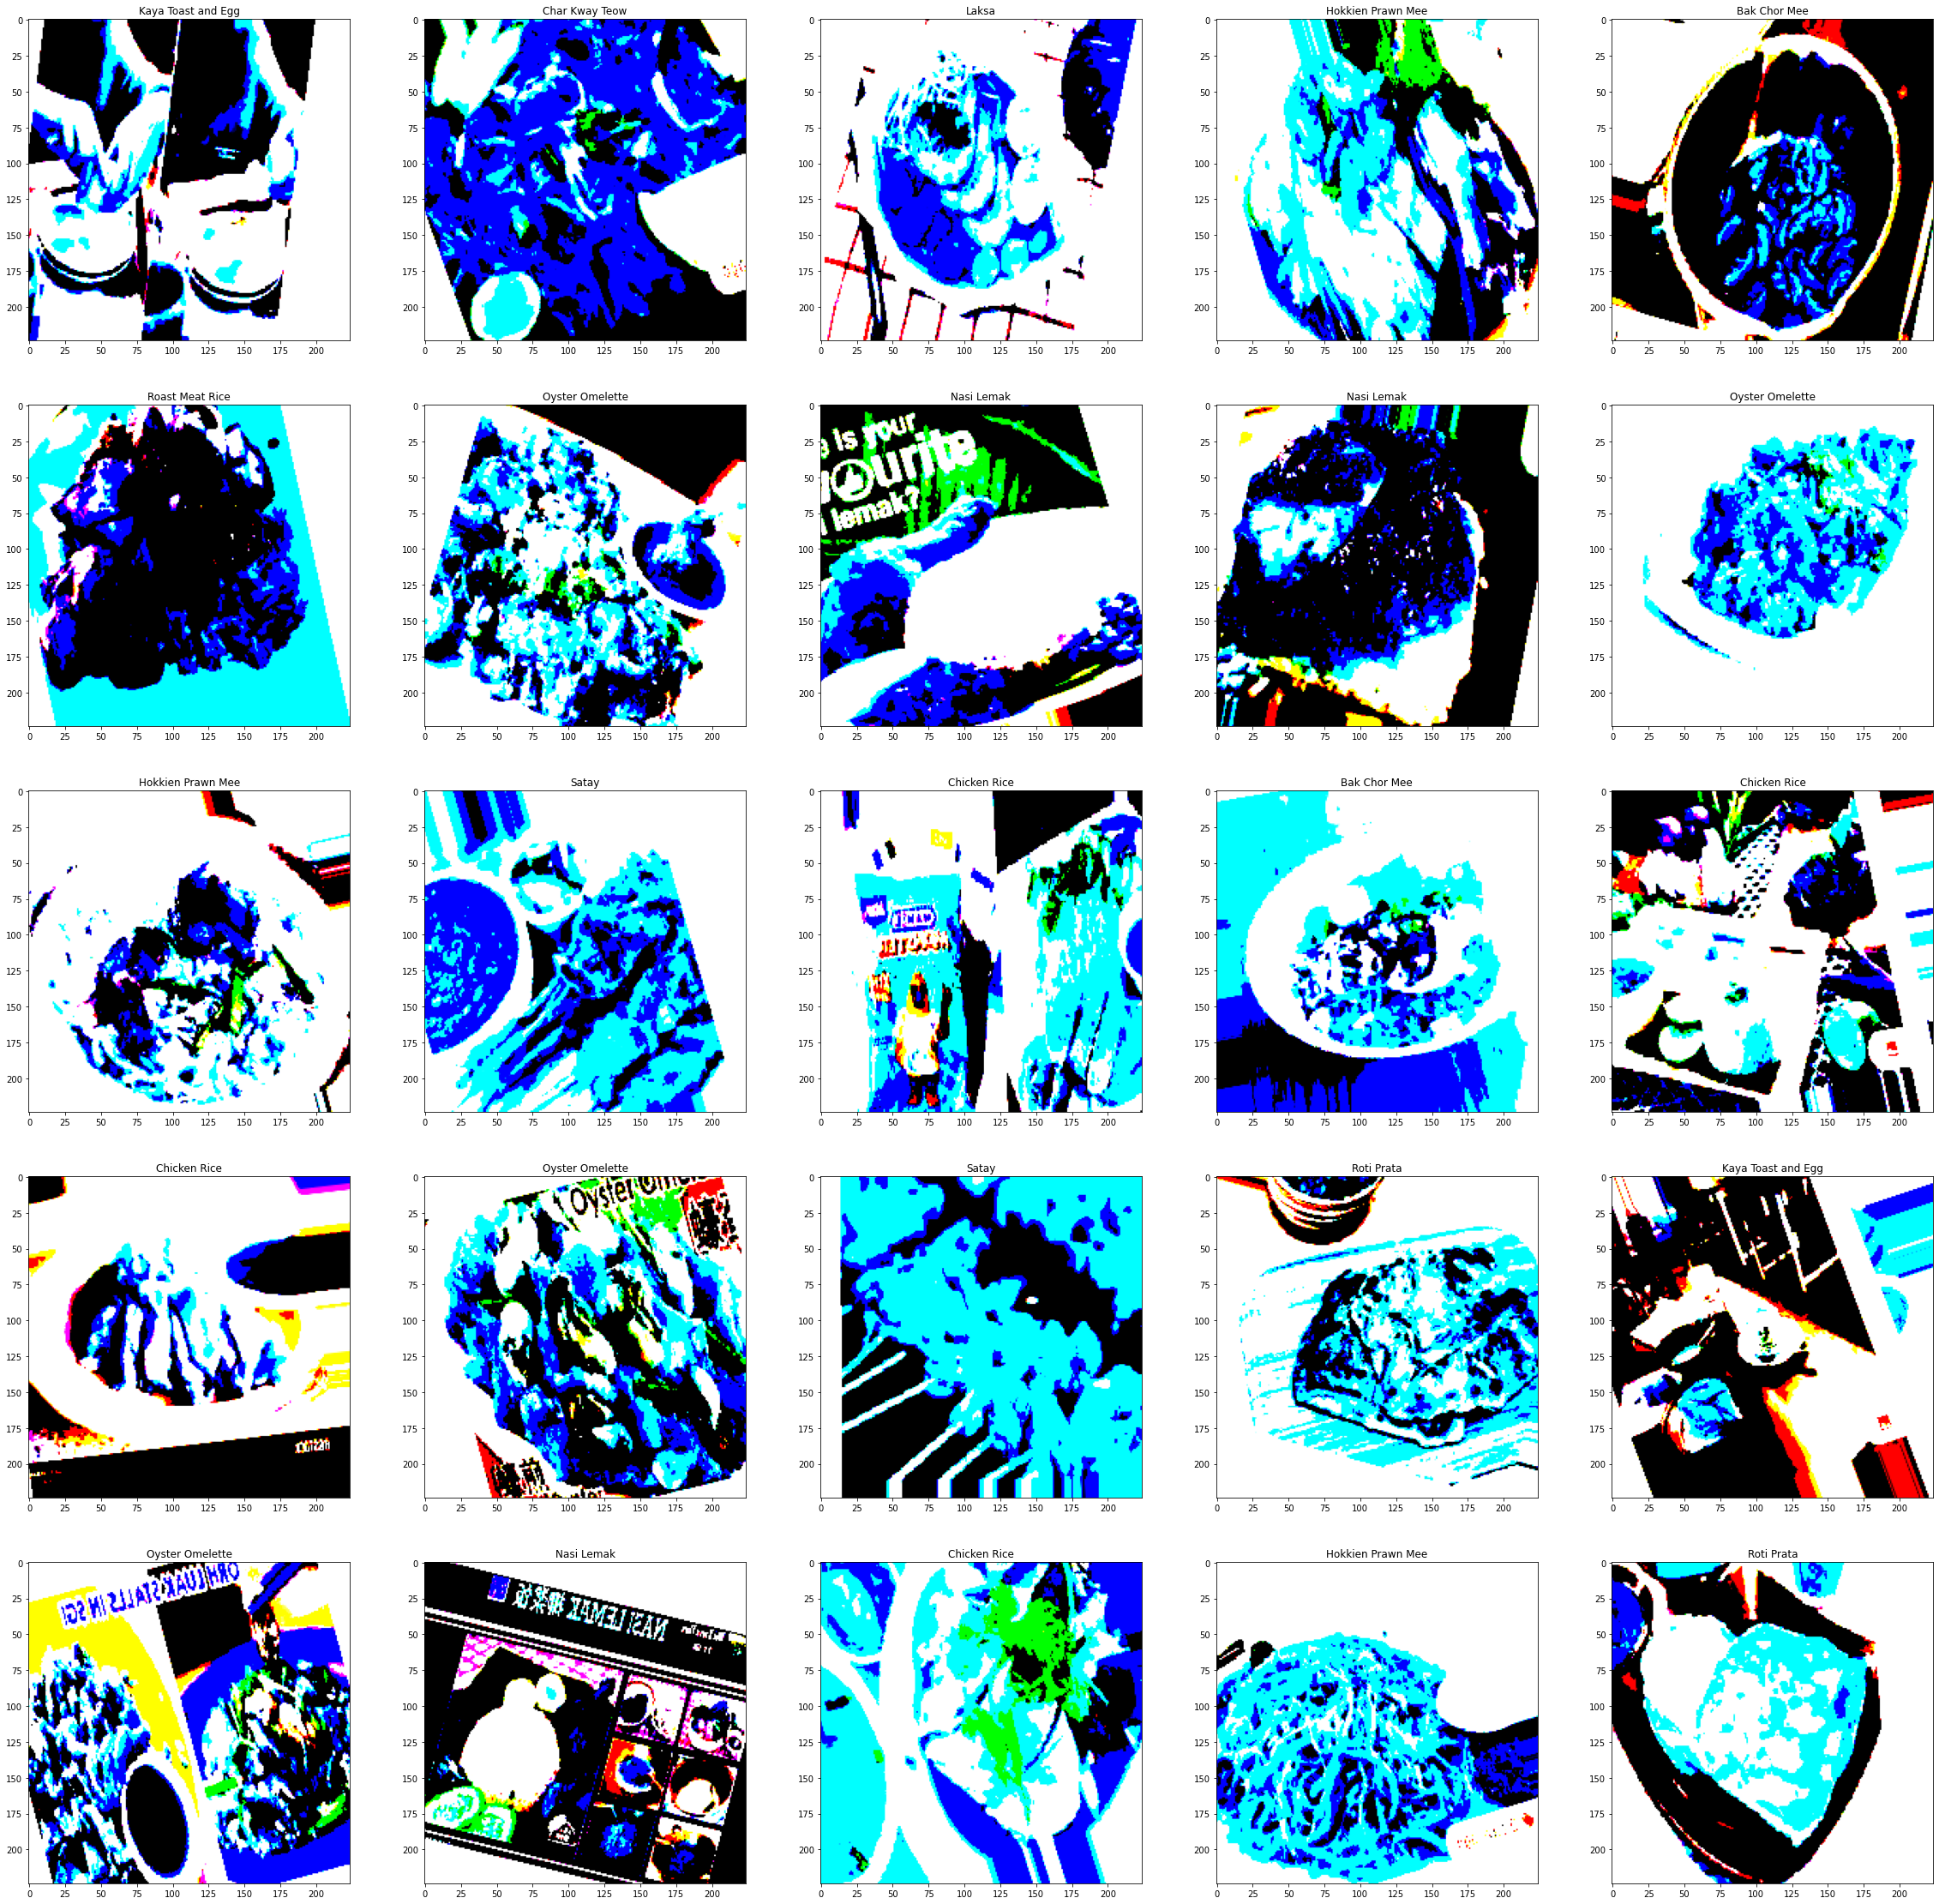

In [5]:
#Preview of images in train_generator
row = 5;column = 5
n=0
classtolabel = {'0':'Bak Chor Mee',"1":'Char Kway Teow', 
                "2":'Chicken Rice', "3":'Hokkien Prawn Mee', "4":'Kaya Toast and Egg', 
                "5":"Laksa", "6": "Nasi Lemak", "7": "Oyster Omelette", "8":"Roast Meat Rice", 
                "9": "Roti Prata", "10":"Satay", "11":"Wanton Mee"}
for x in train_generator:
    fig, axes = plt.subplots(row,column,figsize=(40,40))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

### 5.3: Transfer learning with VGG16

Similar to Mobilenet, we intend to use transfer learning for feature extration and will first have to create our base model (minus the top classifier layer). 

In [6]:
# Creating our base model from the pre-trained VGG16 model
base_model = keras.applications.VGG16(input_shape=(img_width, img_height, 3),
                                            include_top=False,
                                            weights='imagenet')

# Freezing all but the last classifier layer to prevent weights from VGG16 from being updated 
base_model.trainable = False


In [7]:
# Examinining the base model architecture (i.e. VGG16 minus top classifier layer)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# Definining final model structure (base model from VGG16 + 2 Dense layers of our choosing)
model = keras.Sequential([base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(512, activation = "relu",kernel_initializer='he_normal'),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(12, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2())])                          
                       

In [9]:
# Compiling our final model with a learning rate of Adam, 0.0001
top3_acc = keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy')
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

In [10]:
# Examinining the final model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                6156      
Total params: 14,983,500
Trainable params: 268,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# Setting our final model to train on 100 epochs first 
initial_epochs = 100

#We also include an early stopping callback to stop the model from training after 3 epochs 
#if val_loss is not decreasing 
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

# Train model with early stopping
history = model.fit_generator(
    train_generator,
    epochs=initial_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])


Epoch 1/100


/Users/Derrick/miniforge3/envs/tf3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


375/375 [==============================] - ETA: 0s - batch: 187.0000 - size: 32.0000 - loss: 4.6407 - accuracy: 0.3152 - top_3_categorical_accuracy: 0.5931

/Users/Derrick/miniforge3/envs/tf3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


375/375 [==============================] - 287s 766ms/step - batch: 187.0000 - size: 32.0000 - loss: 4.6407 - accuracy: 0.3152 - top_3_categorical_accuracy: 0.5931 - val_loss: 2.0203 - val_accuracy: 0.5800 - val_top_3_categorical_accuracy: 0.8342
Epoch 2/100
375/375 [==============================] - 286s 763ms/step - batch: 187.0000 - size: 32.0000 - loss: 2.1569 - accuracy: 0.5380 - top_3_categorical_accuracy: 0.8038 - val_loss: 1.5445 - val_accuracy: 0.6454 - val_top_3_categorical_accuracy: 0.8800
Epoch 3/100
375/375 [==============================] - 288s 767ms/step - batch: 187.0000 - size: 32.0000 - loss: 1.7075 - accuracy: 0.6024 - top_3_categorical_accuracy: 0.8430 - val_loss: 1.3769 - val_accuracy: 0.6796 - val_top_3_categorical_accuracy: 0.8875
Epoch 4/100
375/375 [==============================] - 287s 765ms/step - batch: 187.0000 - size: 32.0000 - loss: 1.4603 - accuracy: 0.6384 - top_3_categorical_accuracy: 0.8697 - val_loss: 1.2717 - val_accuracy: 0.6975 - val_top_3_categ

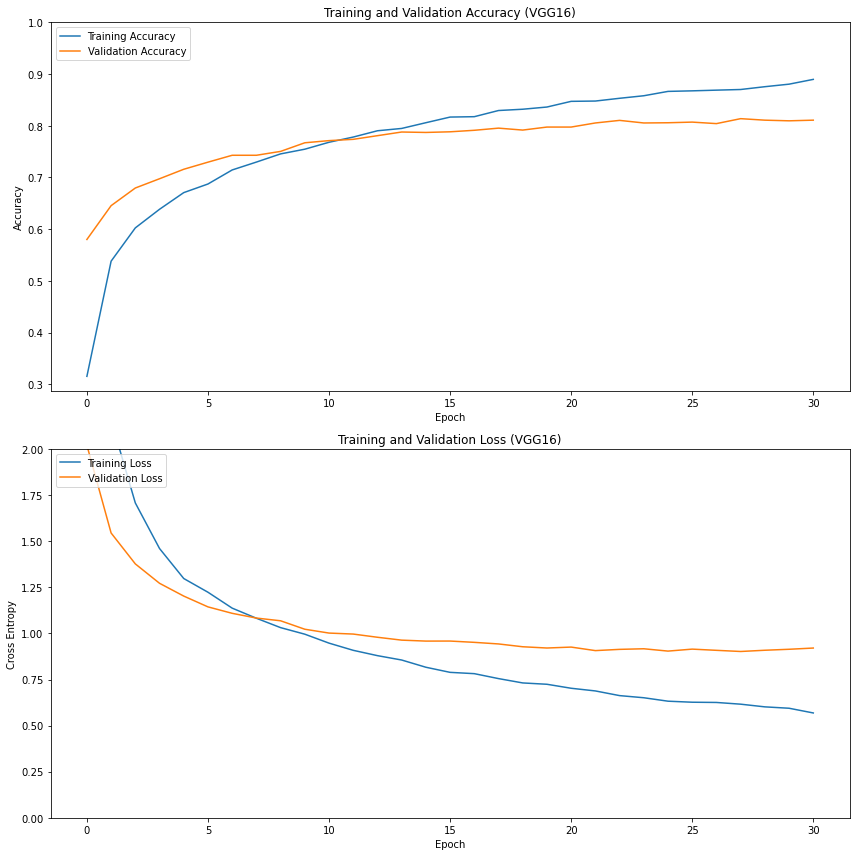

In [12]:
# Plotting accuracies and losses/val_losses of our training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (VGG16)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss (VGG16)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

Based on the two graphs above, we can observe that there is some slight overfitting as the number of epoch increase (since there is a slight gap between our accuracy and val_accuracy lines). That said, we need not be too concerned as the architecture of pre-trained models is known to be complex thereby resulting in some overfitting when applied to foreign images that it has never been pre-trained on. 

In terms of loss function, both our loss and val_loss lines have a decent convex shape. This suggests there is minimisation of our loss function and that we have chosen a good learning rate ([*Source: TowardsDataScience*](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)).

### 5.4: Fine-tuning of final model

To further improve the accuracy of our final model, we will now unfreeze a few of the top layers of the base model to jointly train both the newly-added classifier layers and the last layers of the base model.

In [13]:
#Unfreezing top layers of base model to allow for training
base_model.trainable = True

# Examining how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tuning to start from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [14]:
# Compiling the model using a much lower training rate
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

# Examining model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                6156      
Total params: 14,983,500
Trainable params: 268,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
first_epochs = len(history.history['val_loss'])

fine_tune_epochs = 100
total_epochs =  first_epochs + fine_tune_epochs

# Continue model training 
history_fine_tune = model.fit_generator(
    train_generator,
    epochs=total_epochs,
    initial_epoch = first_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])

Epoch 32/131
375/375 [==============================] - 291s 772ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.5633 - accuracy: 0.8920 - top_3_categorical_accuracy: 0.9825 - val_loss: 0.9206 - val_accuracy: 0.8108 - val_top_3_categorical_accuracy: 0.9467
Epoch 33/131
375/375 [==============================] - 289s 770ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.5604 - accuracy: 0.8910 - top_3_categorical_accuracy: 0.9850 - val_loss: 0.9206 - val_accuracy: 0.8108 - val_top_3_categorical_accuracy: 0.9467
Epoch 34/131
375/375 [==============================] - 288s 769ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.5623 - accuracy: 0.8890 - top_3_categorical_accuracy: 0.9850 - val_loss: 0.9206 - val_accuracy: 0.8108 - val_top_3_categorical_accuracy: 0.9467
Epoch 35/131
375/375 [==============================] - 289s 771ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.5638 - accuracy: 0.8892 - top_3_categorical_accuracy: 0.9827 - val_loss: 0.9206 - val_accuracy: 0.8108 -

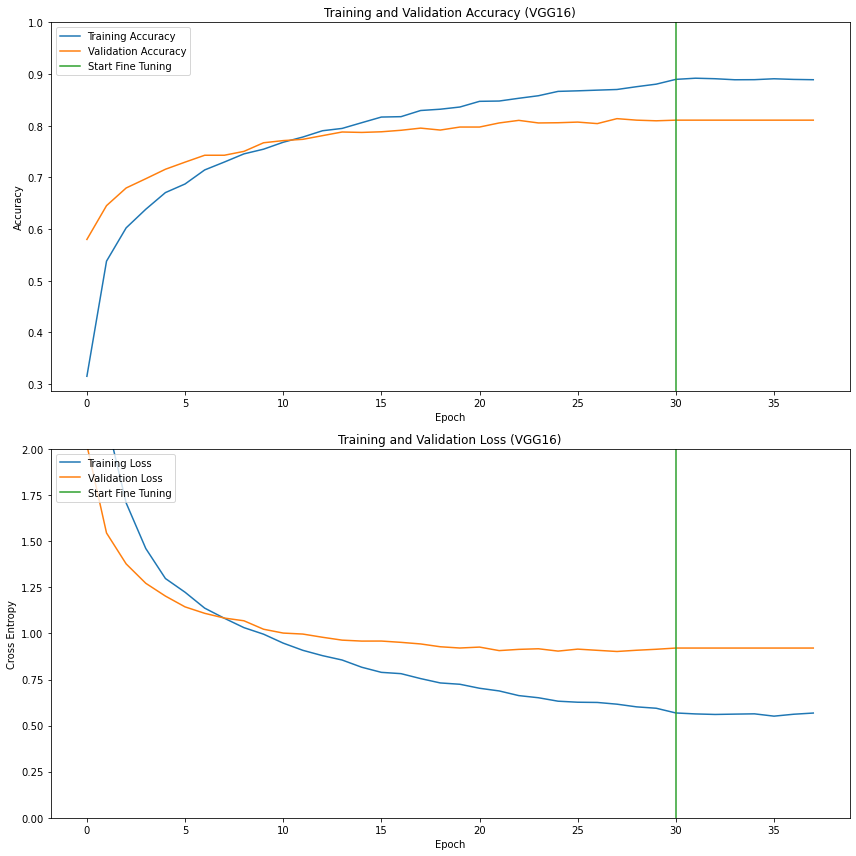

In [16]:
# Plotting accuracies and losses/val_losses of our training and validation sets after fine-tuning

acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([first_epochs-1,first_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (VGG16)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([first_epochs-1,first_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss (VGG16)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [17]:
# Saving our final model  
model.save('./final_model_vgg16.h5')       
          

### 5.5: Prediction and evaluation
To prevent data leakage, we will be evaluating our model using our test set which our model has not seen before (i.e. hold-out set).

In evaluating our model, we will primarily be focusing on its accuracy (i.e. ratio of number of correction predictions to the total number of input images).

In [24]:
# Create  our test generator on our test set (which our model has never seen before) in a single batch 
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=2400,
    class_mode='categorical')

Found 2400 images belonging to 12 classes.


In [25]:
#Generating the true and predicted labels of our test images and evaluating the accuracy score
x_test, y_test = test_generator.next()
y_pred_conf = model.predict(x_test) 
y_pred = np.argmax(y_pred_conf,axis=1)
y_true = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_true,y_pred)*100))

Accuracy score: 80.8%


Our final model (with VGG16 as transfer learning) yields an accuracy score of 80.8% when evaluated using our test set. This means that 80.8 (or ~1939 out of 2400 test images) are accurately classified into their respective hawker food classes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


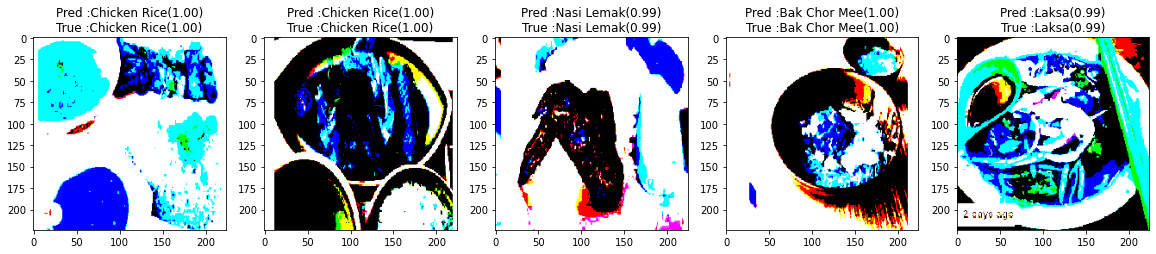

In [26]:
# Printing 5 random images from our test_generator together with their predicted and true labels
ind = np.random.randint(1,len(x_test),5)
fig, axis =plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    axis[i].imshow(x_test[j])
    axis[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_true[j])],y_pred_conf[j][(y_true[j])],fontweight="bold", size=20))

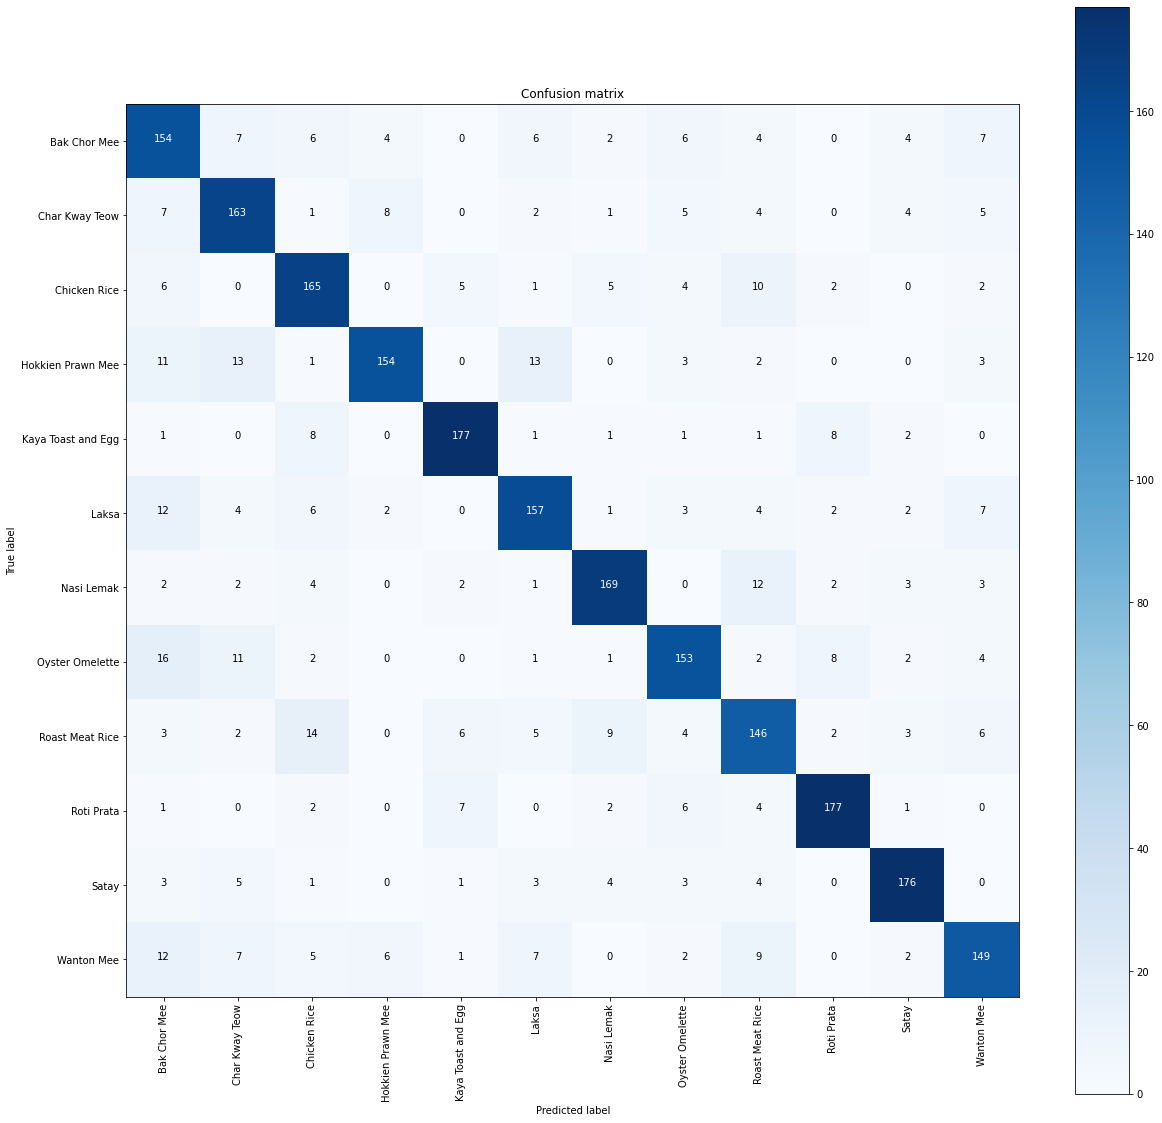

In [27]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    classes = ['Bak Chor Mee', 'Char Kway Teow', 
                'Chicken Rice', 'Hokkien Prawn Mee','Kaya Toast and Egg',
               "Laksa", "Nasi Lemak", "Oyster Omelette", "Roast Meat Rice", "Roti Prata", "Satay", "Wanton Mee"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
classes = ['Bak Chor Mee', 'Char Kway Teow', 
                'Chicken Rice', 'Hokkien Prawn Mee','Kaya Toast and Egg',
               "Laksa", "Nasi Lemak", "Oyster Omelette", "Roast Meat Rice", "Roti Prata", "Satay", "Wanton Mee"]

plt.figure(figsize=(20, 20))   
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=classes, title='Confusion matrix')

From the confusion matrix above, we can observe that our model is generally good at predicting the correct classes since Roast Meat Rice (despite having the lowest accuracy amongst all food classes) has 146/200 images correctly classified.

That said, we noticed that our model tends to struggle with noodle-related images (e.g. 13 Hokkien Prawn Mee images are inaccurately classified as Laksa/Char Kway Teow or that 16 Oyster Omelette images are predicted as Bak Chor Mee). This phenomenon is also observed in other models that we have built. Furthemore, our model seems to have a slight difficulty distinguishing between Roast Meat Rice and Chicken Rice (two classes of hawker food that are closely related to each other).To overcome these issues and as a possible extension to our project, we can consider collecting and training our CNN model on even more images so that it gets better at recognising and predicting noodle-related images.